In [2]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.test.is_built_with_cuda()

True

# Importing Libraries

In [17]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path as op
import pickle

In [18]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model,Sequential,load_model
from keras.layers import Input, Embedding
from keras.layers import Dense, Bidirectional
from keras.layers.recurrent import LSTM
import keras.metrics as metrics
import itertools
from tensorflow.python.keras.utils.data_utils import Sequence
from decimal import Decimal
from keras import backend as K
from keras.layers import Conv1D,MaxPooling1D,Flatten,Dense

# Data Fetching

In [33]:
inp=pd.read_csv("PJ sensor.csv",usecols=[6,7,10,11])
out=pd.read_csv("PJ sensor.csv",usecols=[2,3,4,5,8,9])

In [34]:
inp.head(5)

,Temperature,Relative Humidity,date,Time
0,31,65,191213,175844
1,31,65,191213,175904
2,31,65,191213,175924
3,31,65,191213,175944
4,31,66,191213,180004


In [35]:
out.head(5)

,NO2,O3,CO,SO2,PM2.5,PM10
0,-15.075377,35.714286,1766.233766,148.484848,11.229150,17.323938
1,-20.100503,41.208791,1733.766234,142.424242,9.413914,24.967407
2,-15.075377,43.956044,1711.038961,136.363636,10.350110,56.781536
3,0.000000,57.692308,1688.311688,139.393939,10.488765,30.371115
4,-20.100503,54.945055,1681.818182,130.303030,12.353048,188.026886


In [36]:
inp=np.array(inp)
out=np.array(out)

# Min Max Scaler

In [37]:
from sklearn.preprocessing import MinMaxScaler
import warnings
scaler_obj=MinMaxScaler()
X1=scaler_obj.fit_transform(inp)
Y1=scaler_obj.fit_transform(out)

warnings.filterwarnings(action='ignore', category=UserWarning)

X1=X1[:,np.newaxis,:]
Y1=Y1[:,np.newaxis,:]

In [38]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [39]:
Y1.shape

(1627533, 1, 6)

# Model

In [11]:
model1 = Sequential()
model1.add(keras.Input(shape=(1,4)))
model1.add(tf.keras.layers.GRU(6,activation="relu",use_bias=True,kernel_initializer="glorot_uniform",bias_initializer="zeros", 
                                kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                bias_regularizer=keras.regularizers.l2(1e-4),
                                activity_regularizer=keras.regularizers.l2(1e-5)))
model1.add(keras.layers.Dropout(.1))
model1.add(Dense(6))
model1.add(keras.layers.BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,center=True,scale=True,
                                beta_initializer="zeros",gamma_initializer="ones",
                                moving_mean_initializer="zeros",moving_variance_initializer="ones",trainable=True))
model1.add(keras.layers.ReLU())
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),loss='mse',metrics=['accuracy','mse','mae',rmse])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 6)                 216       
_________________________________________________________________
dropout_1 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
batch_normalization_1 (Batch (None, 6)                 24        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 6)                 0         
Total params: 282
Trainable params: 270
Non-trainable params: 12
_________________________________________________________________


In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

model_fit8 = model1.fit(x_train,y_train,batch_size=2048,epochs=50, validation_split=0.1)

Epoch 1/50
537/537 [==============================] - 150s 278ms/step - loss: 0.2543 - accuracy: 0.0565 - mse: 0.2535 - mae: 0.3347 - rmse: 0.4476 - val_loss: 0.0868 - val_accuracy: 0.0992 - val_mse: 0.0860 - val_mae: 0.2113 - val_rmse: 0.2883
Epoch 2/50
537/537 [==============================] - 145s 269ms/step - loss: 0.2332 - accuracy: 0.0630 - mse: 0.2324 - mae: 0.3229 - rmse: 0.4334 - val_loss: 0.1265 - val_accuracy: 0.0913 - val_mse: 0.1257 - val_mae: 0.2559 - val_rmse: 0.3367
Epoch 3/50
537/537 [==============================] - 145s 270ms/step - loss: 0.2135 - accuracy: 0.0839 - mse: 0.2127 - mae: 0.3105 - rmse: 0.4189 - val_loss: 0.1206 - val_accuracy: 0.1064 - val_mse: 0.1198 - val_mae: 0.2512 - val_rmse: 0.3315
Epoch 4/50
537/537 [==============================] - 146s 271ms/step - loss: 0.1954 - accuracy: 0.1056 - mse: 0.1946 - mae: 0.2985 - rmse: 0.4043 - val_loss: 0.1142 - val_accuracy: 0.1315 - val_mse: 0.1134 - val_mae: 0.2452 - val_rmse: 0.3250
Epoch 5/50
537/537 [====

537/537 [==============================] - 144s 268ms/step - loss: 0.0217 - accuracy: 0.8008 - mse: 0.0211 - mae: 0.0751 - rmse: 0.1141 - val_loss: 0.0222 - val_accuracy: 0.7862 - val_mse: 0.0216 - val_mae: 0.0747 - val_rmse: 0.1149
Epoch 35/50
537/537 [==============================] - 144s 269ms/step - loss: 0.0209 - accuracy: 0.8046 - mse: 0.0203 - mae: 0.0727 - rmse: 0.1108 - val_loss: 0.0214 - val_accuracy: 0.7905 - val_mse: 0.0208 - val_mae: 0.0722 - val_rmse: 0.1112
Epoch 36/50
537/537 [==============================] - 144s 269ms/step - loss: 0.0202 - accuracy: 0.8086 - mse: 0.0196 - mae: 0.0705 - rmse: 0.1075 - val_loss: 0.0208 - val_accuracy: 0.7949 - val_mse: 0.0202 - val_mae: 0.0706 - val_rmse: 0.1087
Epoch 37/50
537/537 [==============================] - 145s 269ms/step - loss: 0.0195 - accuracy: 0.8133 - mse: 0.0189 - mae: 0.0685 - rmse: 0.1045 - val_loss: 0.0203 - val_accuracy: 0.7999 - val_mse: 0.0197 - val_mae: 0.0692 - val_rmse: 0.1067
Epoch 38/50
537/537 [===========

# Saving Model as File

In [26]:
model_json = model1.to_json()
with open("Model_File/grupj.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model1.save_weights("Model_File/grupj.h5")
print("Saved model to disk")

Saved model to disk


In [40]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

from keras.models import model_from_json
json_file = open('Model_File/grupj.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("Model_File/grupj.h5")
print("Loaded model from disk")
loaded_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),loss='mse',metrics=['accuracy','mse','mae',rmse])

Loaded model from disk


In [28]:
loaded_model.evaluate(x_train, y_train, verbose=0)

[0.013080805540084839, 0.8616863489151001, 0.012653610669076443, 0.049101896584033966, 0.0737740769982338]


In [30]:
loaded_model.evaluate(x_test, y_test, verbose=0)

[0.013150591403245926,
 0.8608734607696533,
 0.012723429128527641,
 0.049209967255592346,
 0.07397405803203583]

# Error Analysis

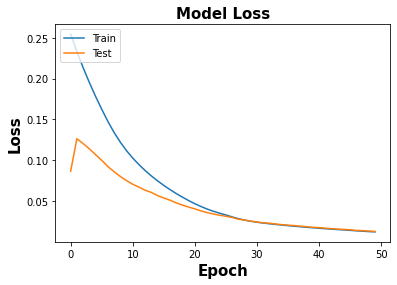

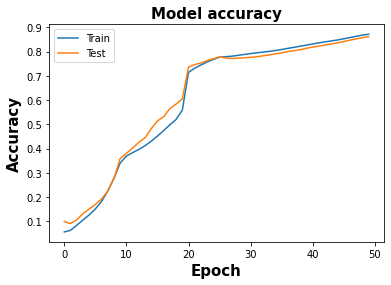

In [16]:
# _, train_acc = model1.evaluate(x_train, y_train, verbose=0)
# _, test_acc = model1.evaluate(x_test, y_test, verbose=0)
# print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# summarize history for loss
plt.plot(model_fit8.history['loss'])
plt.plot(model_fit8.history['val_loss'])
plt.title('Model Loss',fontweight ='bold',fontsize = 15)
plt.ylabel('Loss',fontweight ='bold',fontsize = 15)
plt.xlabel('Epoch',fontweight ='bold',fontsize = 15)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(model_fit8.history['accuracy'])
plt.plot(model_fit8.history['val_accuracy'])
plt.title('Model accuracy',fontweight ='bold',fontsize = 15)
plt.ylabel('Accuracy',fontweight ='bold',fontsize = 15)
plt.xlabel('Epoch',fontweight ='bold',fontsize = 15)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [41]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

y_test_pred=loaded_model.predict(x_test)
y_test_pred

array([[0.38502568, 0.5062915 , 0.03315073, 0.        , 0.04219438,
        0.        ],
       [0.38502568, 0.5062915 , 0.03315073, 0.        , 0.04219438,
        0.        ],
       [0.38502568, 0.5062915 , 0.03315073, 0.        , 0.04219438,
        0.        ],
       ...,
       [0.38502568, 0.5062915 , 0.03315073, 0.        , 0.04219438,
        0.        ],
       [0.38502568, 0.5062915 , 0.03315073, 0.        , 0.04219438,
        0.        ],
       [0.3331288 , 0.47189817, 0.03028788, 0.        , 0.        ,
        0.        ]], dtype=float32)

In [42]:
y_test

array([[[0.49655172, 0.61261671, 0.04625328, 0.00839927, 0.07680226,
         0.00349832]],

       [[0.40689655, 0.56779311, 0.02503314, 0.00862807, 0.03923826,
         0.00169898]],

       [[0.48275862, 0.61261671, 0.05669757, 0.01000087, 0.12197674,
         0.0061505 ]],

       ...,

       [[0.4       , 0.53897794, 0.02967504, 0.01022967, 0.04172884,
         0.01677347]],

       [[0.4137931 , 0.56779311, 0.03514586, 0.01114488, 0.06885241,
         0.003031  ]],

       [[0.48275862, 0.57739817, 0.06051056, 0.00908567, 0.10450044,
         0.00542992]]])

In [43]:
y_test=y_test[:,0]

In [44]:
from numpy import savetxt
savetxt('ARRAY_DATA/gru_y_test_pred.csv', y_test_pred[:1001], delimiter=',')

In [45]:
from numpy import savetxt
savetxt('ARRAY_DATA/gru_y_test.csv', y_test[:1001], delimiter=',')

In [ ]:
#completed